## Sarcasm 新闻标题讽刺检测

### 问题分析

- 问题类型： 二分类问题
- 目标：
    - 输入一段文字
    - 输出：检测是否讽刺
- 挑战：
    - 讽刺的语义较为复杂，常常依赖于上下文、语气、文化背景等因素，难以通过简单的文本模式进行检测
    - 讽刺的语言通常带有隐晦的情感，可能需要模型理解隐藏的情绪。
    - 数据集可能有 类不平衡问题，即讽刺新闻的数量可能少于非讽刺新闻。

### 数据准备
- 数据来源： tfds,已标注的数据
- 数据清洗：检查有无缺失值，不一致的格式
- 数据分割：7:3分割训练/验证集

In [50]:
import matplotlib.pyplot as plt
import tensorflow as tf
import requests

In [51]:
url = "https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json"
response = requests.get(url)
datastore = response.json()

sentences = [] #标题集合
labels = [] #标签 0非讽刺的，1讽刺的
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
print(sentences[0],". label =", labels[0])
print("sentences length ", len(sentences))

former versace store clerk sues over secret 'black code' for minority shoppers . label = 0
sentences length  26709


#### 数据检查和清洗


In [52]:
# 数组转成pandas张量 然后检查和清洗
import pandas as pd
pd_sentences = pd.Series(sentences)
is_null_or_non_string = pd_sentences.isnull() | ~pd_sentences.apply(lambda x: isinstance(x, str))
if is_null_or_non_string.value_counts()[False] == len(sentences):
    print("无null值")
else:
    print(is_null_or_non_string.value_counts())

无null值


In [53]:
pd.Series(labels).value_counts()

0    14985
1    11724
Name: count, dtype: int64

#### 超参数定义

In [54]:
# 多少数据用于训练， 相当于train_test_split_rate
TRAINING_SIZE = 20000
# 只接受这么多token
VOCAB_SIZE = 10000
# Maximum length of the padded sequences
MAX_LENGTH = 32
# 词嵌入维度， 一个token记录16维向量
EMBEDDING_DIM = 16

#### 数据集分割

In [55]:
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]
# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

### 特征工程

- 文本预处理
    - 去除噪声：标点，停用词(the,and)
    - 小写化： 所有字母转小定，确保统一处理
    - 词干提取 或 词形还原
        - 如 running -> run
- 文本表示
    - 子词分词
    - 矢量化
    - 词嵌入

#### 文本预处理

In [57]:
import string
def preprocess_text(text):
    # 1. 小写化
    text = text.lower()
    # 2. 去除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [58]:
print(preprocess_text("Taking everything that you've learned in training a neural network based on NLP, we thought it might be a bit of fun to turn the tables away from classification and use your knowledge for prediction. ")) 
train_sentences = pd.Series(train_sentences).apply(preprocess_text).tolist()
print(train_sentences[0])

taking everything that youve learned in training a neural network based on nlp we thought it might be a bit of fun to turn the tables away from classification and use your knowledge for prediction 
former versace store clerk sues over secret black code for minority shoppers


#### NLP


- 矢量化

In [70]:
## max_tokens 最大惟一单词数量， 超出会优先取词频高的
## output_sequence_length 当vectorize_layer(sentence)方法调用时， 如果长度超出max_length  会截断只有max_len个单词
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                    output_sequence_length=MAX_LENGTH)
vectorize_layer.adapt(sentences)
print(len(vectorize_layer.get_vocabulary()))
# 矢量化语句集
train_sequences = vectorize_layer(train_sentences)
test_sequences = vectorize_layer(test_sentences)

10000


In [71]:
# 数组转tfds
train_dataset_vectorized = tf.data.Dataset.from_tensor_slices((train_sequences,train_labels))
test_dataset_vectorized = tf.data.Dataset.from_tensor_slices((test_sequences,test_labels))

In [72]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize the datasets for training
train_dataset_final = (train_dataset_vectorized.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE))
test_dataset_final = (test_dataset_vectorized.cache().prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE))

### 创建模型



#### 模型选择
- FNN (MLP)
- LSTM
- RNN
- GRU

正则化：
- L2正则化
- Dropout



In [74]:
from keras import Sequential, Input, layers
model = Sequential([
    Input(shape = (MAX_LENGTH, )),
    layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    layers.GlobalAveragePooling1D(),
    layers.Dense(24, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
history = model.fit(train_dataset_final, validation_data=test_dataset_final, epochs=10, verbose=2)

Epoch 1/10
625/625 - 1s - 2ms/step - accuracy: 0.6851 - loss: 0.5820 - val_accuracy: 0.8113 - val_loss: 0.4340
Epoch 2/10
625/625 - 1s - 1ms/step - accuracy: 0.8496 - loss: 0.3601 - val_accuracy: 0.8383 - val_loss: 0.3702
Epoch 3/10
625/625 - 1s - 1ms/step - accuracy: 0.8870 - loss: 0.2826 - val_accuracy: 0.8465 - val_loss: 0.3566
Epoch 4/10
625/625 - 1s - 1ms/step - accuracy: 0.9075 - loss: 0.2354 - val_accuracy: 0.8410 - val_loss: 0.3691
Epoch 5/10
625/625 - 1s - 1ms/step - accuracy: 0.9222 - loss: 0.2016 - val_accuracy: 0.8529 - val_loss: 0.3585
Epoch 6/10
625/625 - 1s - 1ms/step - accuracy: 0.9347 - loss: 0.1757 - val_accuracy: 0.8524 - val_loss: 0.3770
Epoch 7/10
625/625 - 1s - 1ms/step - accuracy: 0.9447 - loss: 0.1520 - val_accuracy: 0.8417 - val_loss: 0.4237
Epoch 8/10
625/625 - 1s - 1ms/step - accuracy: 0.9492 - loss: 0.1391 - val_accuracy: 0.8460 - val_loss: 0.4304
Epoch 9/10
625/625 - 1s - 1ms/step - accuracy: 0.9539 - loss: 0.1244 - val_accuracy: 0.8264 - val_loss: 0.5050
E

### 模型评估

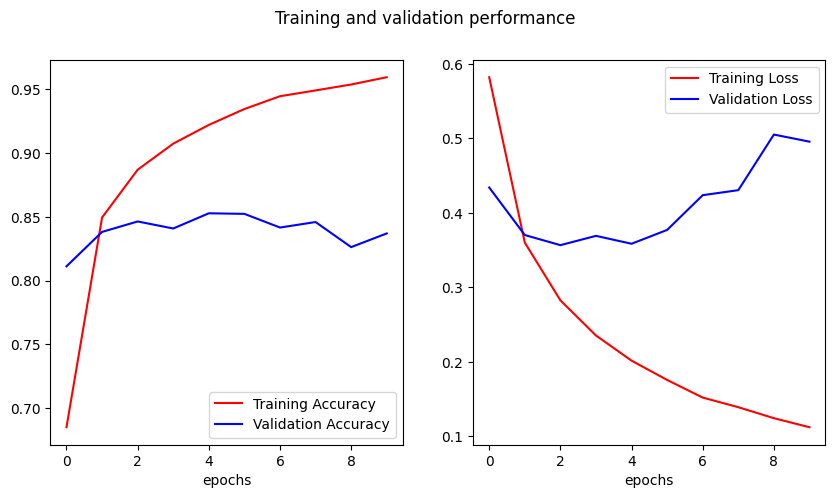

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')